In phase 1 of the [Ag1000G project](http://www.malariagen.net/ag1000g) we have whole genome sequence data for mosquitoes from 9 African countries. As part of our analysis of population structure, I recently needed to calculate average F<sub>ST</sub> between each pair of populations. I also needed to calculate F<sub>ST</sub> in windows over the genome, to look for genome regions that are particularly differentiated between certain populations.

F<sub>ST</sub> is a statistic which seems simple at first yet quickly becomes very technical when you start reading the literature. I asked around my lab for advice and [George](http://www.well.ox.ac.uk/george-busby) pointed me to [Bhatia et al. (2013)](http://www.pubmedcentral.nih.gov/articlerender.fcgi?artid=3759727&tool=pmcentrez&rendertype=abstract) which provides some clear advice on how to estimate F<sub>ST</sub>. However, Bhatia et al. were working with relatively well-studied human populations, and mosquito population genetics can get pretty extreme by comparison, so I didn't want to take anything for granted.

To help explore the impact of different F<sub>ST</sub> estimators and SNP ascertainment schemes, I implemented both the Weir and Cockerham estimator and the Hudson estimator in  [`scikit-allel`](http://scikit-allel.readthedocs.org/en/latest/stats/fst.html). This post gives some examples of using these functions with large scale SNP data, and some practical experiences from applying them to mosquito populations.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zarr
import urllib
import shutil
from pathlib import Path
import zipfile
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import bcolz
import pandas
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.2.0


I'm going to use data from the Ag1000G phase 1 AR3 release. Let's download some data from the Ag1000G public FTP site. The files we're downloading are a few hundred Mb each so this may take a little while, depending on your internet connection.

In [9]:
def download(source_url, dest_path):
    """Helper function to download a remote file to the local file system."""
    with urllib.request.urlopen(source_url) as source:
        with open(dest_path, mode='wb') as dest:
            shutil.copyfileobj(source, dest)

            
# base URL for variation data files to be downloaded
variation_base_url = 'ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/AR3/variation/main/zarr/'
# download files to a local directory called "data"
dest_dir = Path('data')
dest_dir.mkdir(exist_ok=True)

# files to be downloaded
variation_files = [
    'ag1000g.phase1.ar3.pass.biallelic.metadata.zip',
    'ag1000g.phase1.ar3.pass.biallelic.3L.variants.zip',
    'ag1000g.phase1.ar3.pass.biallelic.3L.calldata.GT.zip',
]

for f in variation_files:
    print('downloading', f)
    dest_path = dest_dir / f
    if not dest_path.exists():
        source_url = variation_base_url + f
        download(source_url, dest_path)
    print('extracting', f)
    with zipfile.ZipFile(dest_path, mode='r') as z:
        z.extractall(dest_dir)

# also grab some sample metadata
samples_url = 'ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/AR3/samples/samples.meta.txt'
download(samples_url, dest_dir / 'ag1000g.phase1.ar3.samples.meta.txt')

downloading ag1000g.phase1.ar3.pass.biallelic.metadata.zip
extracting ag1000g.phase1.ar3.pass.biallelic.metadata.zip
downloading ag1000g.phase1.ar3.pass.biallelic.3L.variants.zip
extracting ag1000g.phase1.ar3.pass.biallelic.3L.variants.zip
downloading ag1000g.phase1.ar3.pass.biallelic.3L.calldata.GT.zip
extracting ag1000g.phase1.ar3.pass.biallelic.3L.calldata.GT.zip


In [3]:
callset = zarr.open_consolidated('data/ag1000g.phase1.ar3.pass.biallelic')
callset

<zarr.hierarchy.Group '/'>

Let's work with chromosome arm 3L.

In [42]:
chrom = '3L'
# load all variant positions
pos_all = allel.SortedIndex(callset[chrom]['variants']['POS'])
pos_all

0,1,2,3,4,...,7449481,7449482,7449483,7449484,7449485
9790,9798,9812,9818,9829,...,41956530,41956532,41956537,41956541,41956551


There are 7,449,486 SNPs on this chromosome, genotyped in 765 individuals, so this is a relatively big dataset, too big to work with in memory uncompressed. To cope with larger datasets, scikit-allel can run computations directly against the data on disk, and can also make use of compression to reduce data size.

In [43]:
gt_all = allel.GenotypeDaskArray(callset[chrom]['calldata']['GT'])
gt_all

<GenotypeDaskArray shape=(7449486, 765, 2) dtype=int8>

This array would be 11.4G uncompressed, but [genotype data compress very well](http://alimanfoo.github.io/2016/09/21/genotype-compression-benchmark.html), so the actual size on disk is only 182M.

There is also a table of sample metadata which we'll need because it tells us which mosquito comes from which population.

In [12]:
df_samples = pandas.read_csv('data/ag1000g.phase1.ar3.samples.meta.txt', sep='\t', index_col='index')
df_samples.head()

,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
index,,,,,,,,,,,,,,,
0,AB0085-C,BF2-4,ERS223996,BFS,Burkina Faso,Pala,Austin Burt,Sam O'Loughlin,2012,S,F,89905852,28.01,11.150,-4.235
1,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,116706234,36.76,11.233,-4.472
2,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,112090460,23.30,11.233,-4.472
3,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,145350454,41.36,11.233,-4.472
4,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,105012254,34.64,11.233,-4.472


The 'index' column in this table corresponds to the order of columns in the genotype array.

Let's pick two populations to work with.

In [13]:
pop1 = 'BFM'
pop2 = 'AOM'
n_samples_pop1 = np.count_nonzero(df_samples.population == pop1)
n_samples_pop2 = np.count_nonzero(df_samples.population == pop2)
print(pop1, n_samples_pop1, pop2, n_samples_pop2)

BFM 69 AOM 60


I've chosen BFM (*Anopheles coluzzii* from Burkina Faso) and AOM (*Anopheles coluzzii* from Angola) because F<sub>ST</sub> is reasonably high between these two populations.

Now compute allele counts in each population. This may take a few seconds.

In [20]:
import dask.array as da
from dask.diagnostics import ProgressBar

In [69]:
# sample indices for each population
pop1_idx = df_samples[df_samples.population == pop1].index
pop2_idx = df_samples[df_samples.population == pop2].index

# compute allele counts
with ProgressBar():
    ac1_all = gt_all.count_alleles(max_allele=1, subpop=pop1_idx).compute()
    ac2_all = gt_all.count_alleles(max_allele=1, subpop=pop2_idx).compute()
    

[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  2.8s


Finally, we can filter out variants that aren't segregating in the union of our two populations.

In [71]:
acu = ac1_all + ac2_all
acu

<AlleleCountsArray shape=(7449486, 2) dtype=int32>
258   0
258   0
258   0
...
248  10
258   0
258   0

In [72]:
flt = acu.is_segregating()
print('retaining', np.count_nonzero(flt), 'SNPs')

retaining 2694191 SNPs


In [73]:
pos = pos_all.compress(flt)
ac1 = ac1_all.compress(flt, axis=0)
ac2 = ac2_all.compress(flt, axis=0)
gt = gt_all.compress(flt, axis=0)
gt

<GenotypeDaskArray shape=(2694191, 765, 2) dtype=int8>

## Comparing F<sub>ST</sub> estimators

### Per-SNP estimates

Let's first compute the per-SNP F<sub>ST</sub> value from each of the two estimators. The Weir & Cockerham estimator takes a little longer because it has to revisit the genotype data. The Hudson estimator is faster because it only needs the allele counts, which we've already computed. 

In [74]:
# TODO fully daskify implementation of weir_cockerham_fst
a, b, c = allel.weir_cockerham_fst(gt, subpops=[pop1_idx, pop2_idx], max_allele=1, blen=200000)
snp_fst_wc = (a / (a + b + c))[:, 0]
snp_fst_wc

array([-0.00102459,  0.01277143,  0.08574083, ..., -0.00102459,
        0.0554781 ,  0.08247673])

In [75]:
num, den = allel.hudson_fst(ac1, ac2)
snp_fst_hudson = num / den
snp_fst_hudson

array([0.        , 0.01459854, 0.08403361, ..., 0.        , 0.05042017,
       0.07563025])

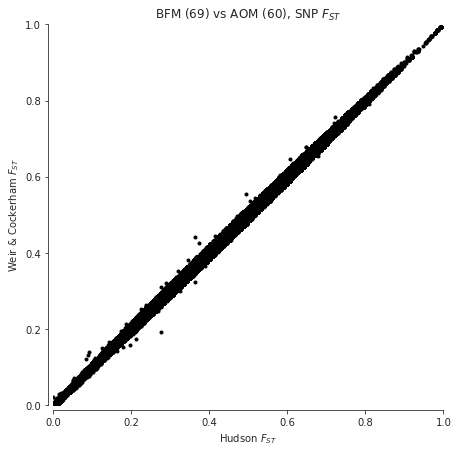

In [41]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.despine(ax=ax, offset=5)
ax.plot(snp_fst_hudson, snp_fst_wc, color='k', marker='.', linestyle=' ')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Hudson $F_{ST}$')
ax.set_ylabel('Weir & Cockerham $F_{ST}$')
ax.set_title('%s (%s) vs %s (%s), SNP $F_{ST}$' % (pop1, n_samples_pop1, pop2, n_samples_pop2));

With a couple of exceptions, the two estimators are virtually identical for all SNPs. However, one thing that Bhatia et al. warn is that the Weir & Cockerham estimator can give different results if sample sizes are unequal. We've chosen two populations with similar sample sizes, but what happens if we fake one of the populations to have a much smaller sample size?

In [49]:
# keep only 20 samples from first population
pop1_idx_ds = subpops[pop1][:20]
a, b, c = allel.weir_cockerham_fst(gt, subpops=[pop1_idx_ds, pop2_idx], max_allele=1, blen=200000)
# there may be some non-segregating variants after down-sampling, suppress errors about zero division
with np.errstate(divide='ignore', invalid='ignore'):
    snp_fst_wc_ds = (a / (a + b + c))[:, 0]
snp_fst_wc_ds

array([       nan, 0.03306823, 0.03605869, ...,        nan, 0.02435467,
       0.04264706])

In [50]:
np.count_nonzero(np.isnan(snp_fst_wc_ds))

934232

In [51]:
# recompute allele counts for downsampled population
ac1_ds = gt.count_alleles(subpop=pop1_idx_ds, max_allele=1).compute()
num, den = allel.hudson_fst(ac1_ds, ac2)
# there may be some non-segregating variants after down-sampling, suppress errors about zero division
with np.errstate(divide='ignore', invalid='ignore'):
    snp_fst_hudson_ds = num / den
snp_fst_hudson_ds

array([       nan, 0.        , 0.08403361, ...,        nan, 0.05042017,
       0.07563025])

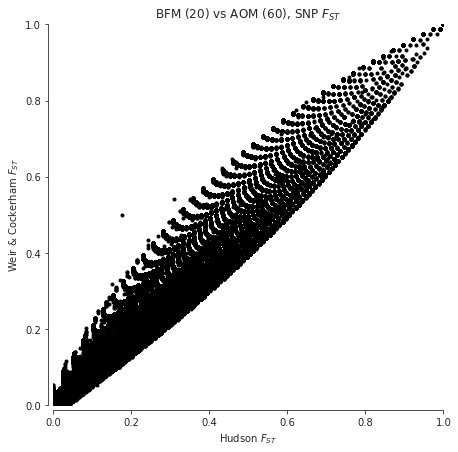

In [53]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.despine(ax=ax, offset=5)
ax.plot(snp_fst_hudson_ds, snp_fst_wc_ds, color='k', marker='.', linestyle=' ')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Hudson $F_{ST}$')
ax.set_ylabel('Weir & Cockerham $F_{ST}$')
ax.set_title('%s (20) vs %s (%s), SNP $F_{ST}$' % (pop1, pop2, n_samples_pop2));

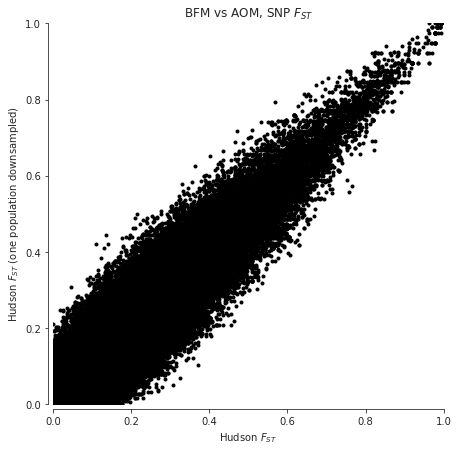

In [55]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.despine(ax=ax, offset=5)
ax.plot(snp_fst_hudson, snp_fst_hudson_ds, color='k', marker='.', linestyle=' ')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Hudson $F_{ST}$')
ax.set_ylabel('Hudson $F_{ST}$ (one population downsampled)')
ax.set_title('%s vs %s, SNP $F_{ST}$' % (pop1, pop2));

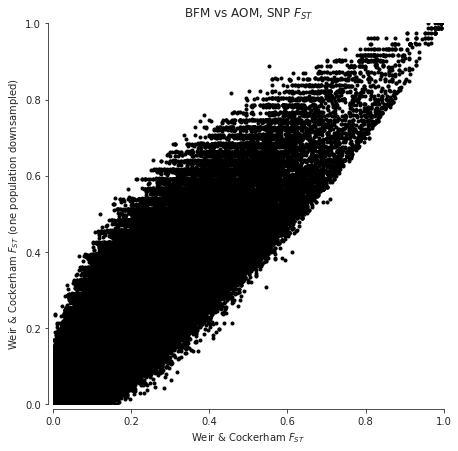

In [56]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.despine(ax=ax, offset=5)
ax.plot(snp_fst_wc, snp_fst_wc_ds, color='k', marker='.', linestyle=' ')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Weir & Cockerham $F_{ST}$')
ax.set_ylabel('Weir & Cockerham $F_{ST}$ (one population downsampled)')
ax.set_title('%s vs %s, SNP $F_{ST}$' % (pop1, pop2));

When the sample sizes are unequal, the correspondance between the two estimators is clearly much less. Also, the Weir & Cockerham estimator appears to be systematically different with and without one population down-sampled.

### Chromosome average estimates

Now compute chromosome-wide average F<sub>ST</sub> with standard errors approximated via a block-jackknife.

In [58]:
# TODO fix this!
fst_wc, se_wc, vb_wc, _ = allel.average_weir_cockerham_fst(gt, subpops=[pop1_idx, pop2_idx], 
                                                           blen=10000, max_allele=1)
print('%.04f +/- %.04f (Weir & Cockerham)' % (fst_wc, se_wc))

TypeError: 'tuple' object cannot be interpreted as an integer

In [59]:
fst_hudson, se_hudson, vb_hudson, _ = allel.average_hudson_fst(ac1, ac2, blen=10000)
print('%.04f +/- %.04f (Hudson)' % (fst_hudson, se_hudson))

0.1085 +/- 0.0034 (Hudson)


The two estimates are very close, well within one standard error.

How about with one population downsampled to 20?

In [61]:
# TODO fix this!
fst_wc_ds, se_wc_ds, _, _ = allel.average_weir_cockerham_fst(gt, subpops=[pop1_idx_ds, pop2_idx], 
                                                             blen=10000, max_allele=1)
print('%.04f +/- %.04f (Weir & Cockerham)' % (fst_wc_ds, se_wc_ds))

TypeError: 'tuple' object cannot be interpreted as an integer

In [62]:
fst_hudson_ds, se_hudson_ds, _, _ = allel.blockwise_hudson_fst(ac1_ds, ac2, blen=10000)
print('%.04f +/- %.04f (Hudson)' % (fst_hudson_ds, se_hudson_ds))

0.1077 +/- 0.0033 (Hudson)


The two estimates are now separated by about two standard errors, with the Weir & Cockerham estimator inflated relative to the estimate with full samples from both populations

## SNP ascertainment

Another issue that Bhatia et al. discuss is SNP ascertainment. Basically, how you choose which SNPs to use when estimating F<sub>ST</sub> can make a difference. As I understand it, when computing average F<sub>ST</sub> you want to use a set of SNPs which segregated in the ancestral population, because changes in allele frequency at these SNPs will tell you something about genetic drift. 

Bhatia et al. recommend ascertaining SNPs by choosing SNPs that are segregating in a third "outgroup" population. However, we don't really have an obvious outgroup population in Ag1000G. So we then have four choices: (1) choose SNPs segregating in the first population; (2) choose SNPs segregating in the second population; (3) choose SNPs segregating in either population; (4) choose SNPs segregating in both populations.

Let's explore the impact of different ascertainment schemes, using the Hudson estimator.

In [76]:
def compute_fst(ac1, ac2, scheme):
    
    if scheme == 'first':
        loc_asc = ac1.is_segregating()
    elif scheme == 'second':
        loc_asc = ac2.is_segregating()
    elif scheme == 'either':
        loc_asc = ac1.is_segregating() | ac2.is_segregating()
    elif scheme == 'both':
        loc_asc = ac1.is_segregating() & ac2.is_segregating()    
    n_snps = np.count_nonzero(loc_asc)
    
    ac1 = ac1.compress(loc_asc, axis=0)
    ac2 = ac2.compress(loc_asc, axis=0)
    
    fst, se, _, _ = allel.average_hudson_fst(ac1, ac2, blen=10000)
    
    print('%.04f +/- %.04f (using %s SNPs segregating in %s population)' % (fst, se, n_snps, scheme))

In [78]:
for scheme in 'first', 'second', 'either', 'both':
    compute_fst(ac1, ac2, scheme)

0.1045 +/- 0.0034 (using 2367975 SNPs segregating in first population)
0.1160 +/- 0.0045 (using 923531 SNPs segregating in second population)
0.1085 +/- 0.0034 (using 2694191 SNPs segregating in either population)
0.1118 +/- 0.0051 (using 597315 SNPs segregating in both population)


The spread of values here is more than three standard errors, so clearly ascertainment makes a difference. Here I'd be inclined to use SNPs segregating in both populations as it is a stricter criterion, however comments very welcome.

## Genome plot

Finally, let's plot F<sub>ST</sub> over the chromosome, to see if any regions are particularly differentiated.

In [79]:
def plot_fst(ac1, ac2, pos, blen=2000):
    
    fst, se, vb, _ = allel.average_hudson_fst(ac1, ac2, blen=blen)
    
    # use the per-block average Fst as the Y coordinate
    y = vb
    
    # use the block centres as the X coordinate
    x = allel.moving_statistic(pos, statistic=lambda v: (v[0] + v[-1]) / 2, size=blen)
    
    # plot
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.despine(ax=ax, offset=5)
    ax.plot(x, y, 'k-', lw=.5)
    ax.set_ylabel('$F_{ST}$')
    ax.set_xlabel('Chromosome %s position (bp)' % chrom)
    ax.set_xlim(0, pos.max())
    

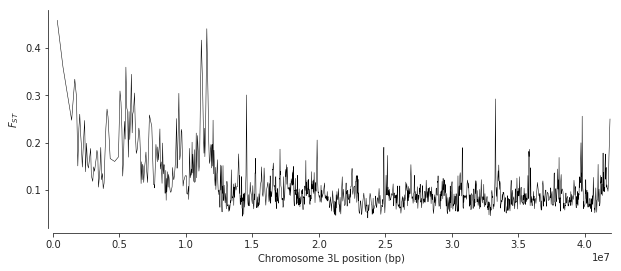

In [80]:
plot_fst(ac1, ac2, pos)

This plot suggests some genome regions where F<sub>ST</sub> is higher than the chromosome-wide average, which are interesting to follow up.

## Conclusions

Hudson's F<sub>ST</sub> estimator is more robust to unequal sample sizes, and faster to compute because it only requires allele counts as input. 

SNP ascertainment also makes a difference. It's probably a good idea to try different ascertainment schemes to see what impact they have on the results. 

## Further reading

* Bhatia, G., Patterson, N., Sankararaman, S., & Price, A. L. (2013). [Estimating and interpreting FST: the impact of rare variants](http://doi.org/10.1101/gr.154831.113). Genome Research, 23(9), 1514–21. 
* [`scikit-allel` F<sub>ST</sub> functions](http://scikit-allel.readthedocs.org/en/latest/stats/fst.html)

<hr/>

In [81]:
import datetime
print(datetime.datetime.now().isoformat())

2019-06-14T00:03:44.887240
